In [1]:
import pandas as pd
import seaborn as sns

# We'll be making splits after cleaning
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")

# Explore Original Dataset

Shaggy pulled his dataset from [johnbradley/Kydoimos](https://huggingface.co/datasets/johnbradley/Kydoimos). There's not much information there, but we can at least look at the original data and sort through it to get a usable dataset. The MD5s from Fred's attempt at re-alignment will be particularly helpful!

**DISCLAIMER:** This is a toy example intended to demonstrate real-world challenges in data collection & curation in a digestible format; in reality, more data would be required for such a project.

In [2]:
df = pd.read_csv("../data/kydoimos.csv", low_memory = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   110 non-null    object
 1   NHM specimen number  110 non-null    int64 
 2   View                 110 non-null    object
 3   Species              110 non-null    object
 4   Subspecies           110 non-null    object
 5   Sex                  110 non-null    object
 6   Type Status          2 non-null      object
 7   md5                  110 non-null    object
dtypes: int64(1), object(7)
memory usage: 7.0+ KB


In [3]:
df.head()

,id,NHM specimen number,View,Species,Subspecies,Sex,Type Status,md5
0,KDS000000,10428329,dorsal,melpomene,thelxiopeia,male,NaN,bfe69135302b78cef66df623ddb5befd
1,KDS000001,10428329,ventral,melpomene,thelxiopeia,male,NaN,c860654219c233d353277b049610bae4
2,KDS000002,10428331,dorsal,melpomene,thelxiopeia,female,NaN,e721585817681ef60e5d0ab81ca00cfd
3,KDS000003,10428331,ventral,melpomene,thelxiopeia,female,NaN,8117d2fbcd85266ea26fc9952b7b23c7
4,KDS000004,10428332,dorsal,melpomene,thelxiopeia,female,NaN,57427dc88037f13f257e3bf52942b2fc


In [4]:
df["Type Status"].value_counts()

Type Status
HT    2
Name: count, dtype: int64

In [5]:
print(f"We have {df.Subspecies.nunique()} unique subspecies and Type Status is in")
df.loc[df["Type Status"].notna(), "Subspecies"].nunique()

We have 6 unique subspecies and Type Status is in


1

Nearly all of column `Type Status` is null, and it's only in one included subspecies. I believe it has to do with hybrids or species recognition, but we should probably ask a biologist....(Cue question to the room, fill in given answer and we'll drop) let's drop it.

We'll make a note that it's being removed (in the Data Curation Section) since it's nearly all null and not applicable across the dataset.

In [6]:
cols = [col for col in list(df.columns) if col != "Type Status"]
df = df[cols]

In [7]:
df.head()

,id,NHM specimen number,View,Species,Subspecies,Sex,md5
0,KDS000000,10428329,dorsal,melpomene,thelxiopeia,male,bfe69135302b78cef66df623ddb5befd
1,KDS000001,10428329,ventral,melpomene,thelxiopeia,male,c860654219c233d353277b049610bae4
2,KDS000002,10428331,dorsal,melpomene,thelxiopeia,female,e721585817681ef60e5d0ab81ca00cfd
3,KDS000003,10428331,ventral,melpomene,thelxiopeia,female,8117d2fbcd85266ea26fc9952b7b23c7
4,KDS000004,10428332,dorsal,melpomene,thelxiopeia,female,57427dc88037f13f257e3bf52942b2fc


## Rename Column with Space

Spaces in column names makes things more complicated, so let's simplify the `NHM specimen number` column name (we will need to document that too).


In [8]:
df.rename(columns= {"NHM specimen number": "NHM_specimen_number"}, inplace = True)

Fred said Shaggy's data had some duplication, so let's check on our unique values here.

In [9]:
df.nunique()

id                     110
NHM_specimen_number     38
View                     4
Species                  2
Subspecies               6
Sex                      4
md5                     76
dtype: int64

It seems we only actually have 76 unique images of 38 specimens.

What are all those different views? And different sexes?

In [10]:
print(df.View.unique())
print(df.Sex.unique())

['dorsal' 'ventral' 'Ventral' 'dorsal ']
['male' 'female' 'Female' 'male ']


Ah, we have `dorsal` and `dorsal ` in addition to variations in case for the `ventral` label. Similar issue with `male` and `female` labels.

Let's standardize all of these to just the lowercase without a trailing space.

In [11]:
df["View"] = df.View.str.lower()
df["Sex"] = df.Sex.str.lower()
df.loc[df["View"] == "dorsal ", "View"] = "dorsal"
df.loc[df["Sex"] == "male ", "Sex"] = "male"

# Now look at distribution
print(df.View.value_counts())
df.Sex.value_counts()

View
dorsal     55
ventral    55
Name: count, dtype: int64


Sex
male      64
female    46
Name: count, dtype: int64

That's a bit cleaner, but we still have a disagreement between unique IDs, specimen numbers, and MD5s!

We don't want to lose metadata or keep an incorrect labelling, so let's check the duplication on MD5, View, Species, and Subspecies values.
We'll check all the duplicates as a whole first.

In [12]:
df["duplicates"] = df.duplicated("md5", keep = False)
df["duplicates"].value_counts()

duplicates
True     68
False    42
Name: count, dtype: int64

In [13]:
duplicates = df.loc[df["duplicates"]]
duplicates.nunique()

id                     68
NHM_specimen_number    17
View                    2
Species                 2
Subspecies              3
Sex                     2
md5                    34
duplicates              1
dtype: int64

So all of our `id`s are unique, but we seem to have duplicates of 34 images. This is across both species, sexes, and views, as well as 3 of the 6 subspecies.

Let's check for consistency across this metadata for each image.

In [14]:
STATS_COLS = ["NHM_specimen_number", "Species", "Subspecies", "View", "Sex", "md5"]
duplicates.duplicated(STATS_COLS, keep = "first").value_counts()

False    34
True     34
Name: count, dtype: int64

Great, it's an even split, so we'll just keep the first instance of each.

In [15]:
df["duplicates"] = df.duplicated(STATS_COLS, keep = "first")
df["duplicates"].value_counts()

duplicates
False    76
True     34
Name: count, dtype: int64

In [16]:
cleaned_df = df.loc[~df["duplicates"]]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 75
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   76 non-null     object
 1   NHM_specimen_number  76 non-null     int64 
 2   View                 76 non-null     object
 3   Species              76 non-null     object
 4   Subspecies           76 non-null     object
 5   Sex                  76 non-null     object
 6   md5                  76 non-null     object
 7   duplicates           76 non-null     bool  
dtypes: bool(1), int64(1), object(6)
memory usage: 4.8+ KB


In [17]:
cleaned_df.nunique()

id                     76
NHM_specimen_number    38
View                    2
Species                 2
Subspecies              6
Sex                     2
md5                    76
duplicates              1
dtype: int64

In [18]:
# Remove duplicates column (only run once!)
cleaned_df = cleaned_df[list(cleaned_df.columns)[:-1]]

### Check Distribution of Data

<Axes: xlabel='Count', ylabel='Subspecies'>

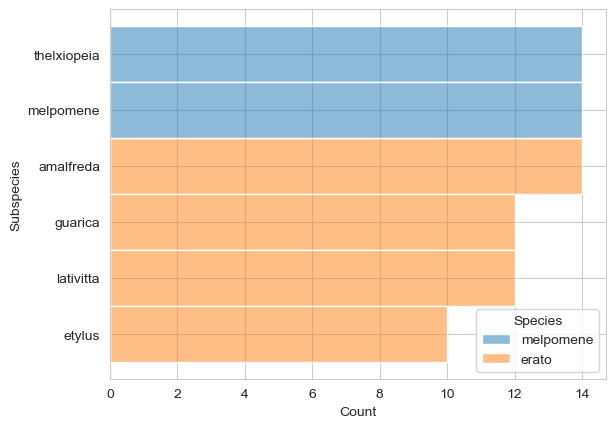

In [19]:
sns.histplot(cleaned_df, y = "Subspecies", hue = "Species")

<Axes: xlabel='Count', ylabel='Subspecies'>

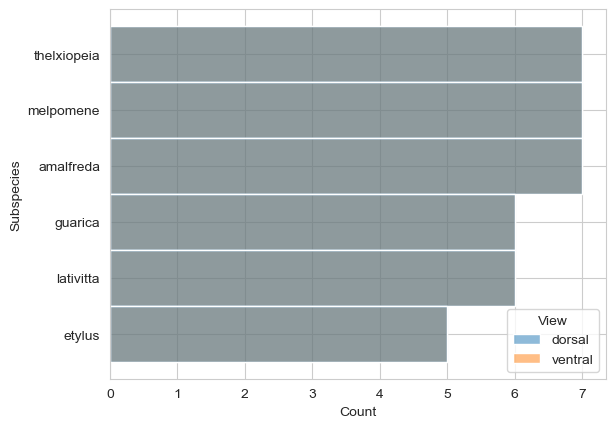

In [20]:
sns.histplot(cleaned_df, y = "Subspecies", hue = "View")

We have perfect balance of dorsal and ventral images.

<Axes: xlabel='Count', ylabel='Subspecies'>

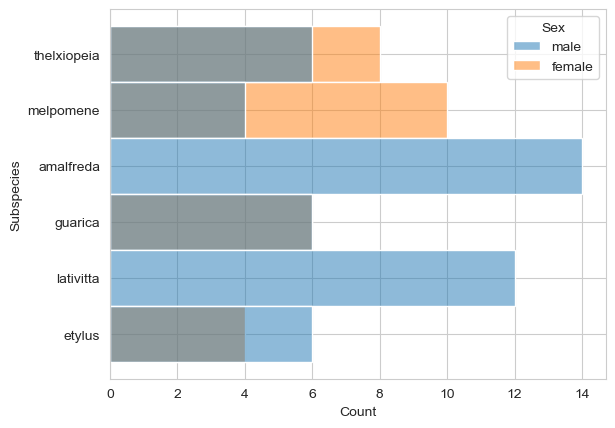

In [21]:
sns.histplot(cleaned_df, y = "Subspecies", hue = "Sex")

We can't train an unbiased model to predict sex with only one sex represented for a subspecies, so we'll remove `amalfreda` and `lativitta` until we can maybe get more data in the future, but first let's save the cleaned dataset as it may be useful elsewhere.

### Save Master Dataset File

Let's save this cleaned up dataset file for easier reference later.

In [21]:
cleaned_df.to_csv("../data/kydoimos_cleaned.csv", index = False)

## Make Splits

Remove skewed subspecies.

In [22]:
skewed_ssp = ["amalfreda", "lativitta"]
reduced_df = cleaned_df.loc[~cleaned_df["Subspecies"].isin(skewed_ssp)].copy()

reduced_df.nunique()

id                     50
NHM_specimen_number    25
View                    2
Species                 2
Subspecies              4
Sex                     2
md5                    50
dtype: int64

In [23]:
# Get list of subspecies included for Dataset Card
reduced_df.Subspecies.unique()

array(['thelxiopeia', 'melpomene', 'guarica', 'etylus'], dtype=object)

Before we can make our splits, let's separate out a dorsal subset from the ventral. This way we can maintain uniqueness of specimens across splits. We'll add in the ventral images to each split based on specimen ID being in the training list or the test list for the dorsal images.

In [24]:
dorsal_df = reduced_df.loc[reduced_df["View"] == "dorsal"].copy()

# Quick check on uniqueness within this subset
dorsal_df.nunique()

id                     25
NHM_specimen_number    25
View                    1
Species                 2
Subspecies              4
Sex                     2
md5                    25
dtype: int64

<Axes: xlabel='Count', ylabel='Subspecies'>

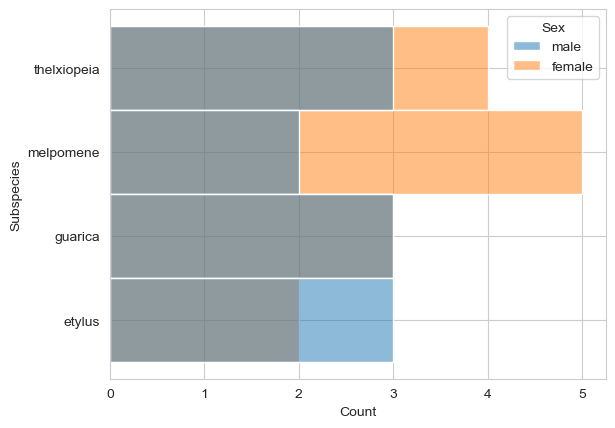

In [25]:
sns.histplot(dorsal_df, y = "Subspecies", hue = "Sex")

It's still not balanced so let's stratify on `Sex` and `Species` (close enough balance), set a `random_state` for reproducibility.

Not a large enough sample of images for stratifying on `Subspecies` (as we should)-—`stratify` ensures split distributions are representative of the distributions in the data

In [26]:
train_df, test_df = train_test_split(dorsal_df, 
                                     test_size = .2,
                                     stratify = dorsal_df[["Sex", "Species"]],
                                     random_state = 614)

### Add Ventral Images to Splits

Let's get a list of each split's specimen IDs so we can align all our images accordingly.

In [27]:
#train_ids = list(train_df["NHM_specimen_number"].unique())
test_ids = list(test_df["NHM_specimen_number"].unique())

In [28]:
# Now assign images
reduced_df["split"] = "train"
reduced_df.loc[reduced_df["NHM_specimen_number"].isin(test_ids), "split"] = "test"

# Check
reduced_df.split.value_counts()

split
train    40
test     10
Name: count, dtype: int64

We have a nice 80-20 split that should be representative of our data and will not have any data leakage as we have removed duplicate images and assigned all images of a specimen to the same split.

### Save our Completed Dataset

Let's save this dataset with the split column. We can start thinking about training now!

In [29]:
reduced_df.to_csv("../data/ButterflyImages_metadata.csv", index = False)